In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


In [ ]:
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser

from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
import tensorflow as tf
import pickle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# fix the random generator for reproducibility
import numpy as np
np.random.seed(7)

In [ ]:
CLASS_NAMES = ["Dry","Wet","Dirty"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
basePath = "/content/drive/MyDrive/OIP_Dataset"

In [ ]:
# build the paths to the data files
trainXPath = os.path.join(basePath, "trainX.cpickle")
testXPath = os.path.join(basePath, "testX.cpickle")
trainYPath = os.path.join(basePath, "trainY.cpickle")
testYPath = os.path.join(basePath, "testY.cpickle")

# load the data files 
print("[INFO] loading data files...")
trainX = pickle.loads(open(trainXPath, "rb").read())
trainY = pickle.loads(open(trainYPath, "rb").read())
testX = pickle.loads(open(testXPath, "rb").read())
testY = pickle.loads(open(testYPath, "rb").read())

[INFO] loading data files...


In [ ]:
# account for skew in the labeled data
trainY = np.array(trainY)
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals


In [ ]:
# dimensions of our images.
img_width, img_height = 224, 224 # we set the img_width and img_height according to the pretrained models we are
# going to use. The input size for ResNet-50 is 224 by 224 by 3.

batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                              height_shift_range=0.1, shear_range=0.2,
                              zoom_range=0.2, horizontal_flip=True, 
                              vertical_flip=True, fill_mode="nearest")

val_datagen = ImageDataGenerator()

mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_datagen.mean = mean
val_datagen.mean = mean

train_generator = train_datagen.flow(
    trainX,
    trainY,
    batch_size=batch_size,
    shuffle=True,
    seed=42)


test_generator = val_datagen.flow(
    testX,
    testY,
    batch_size=batch_size,
    shuffle=False,
    seed=42)

In [ ]:
print(len(trainX),len(testX))

3349 838


In [ ]:
# Define model with different applications
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D
model = Sequential()

model.add(applications.ResNet50(include_top=False,input_tensor=None,input_shape=(224,224,3),pooling='avg',classes = len(CLASS_NAMES),weights='imagenet'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(len(CLASS_NAMES), activation='sigmoid')) #sigmoid


model.layers[0].trainable = False
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 2048)              0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 512)               1049088   
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 512)               0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 512)               2048      
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 3)                 1539      
Total params: 24,640,387
Trainable params: 1,051,651
Non-

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.00009),loss='categorical_crossentropy',metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Train model
epochs = 64
history = model.fit_generator(train_generator,validation_data=test_generator,
                              epochs= epochs, steps_per_epoch=trainX.shape[0]//batch_size,verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/64
104/104 [==============================] - 88s 535ms/step - loss: 1.0410 - accuracy: 0.5568 - val_loss: 0.5879 - val_accuracy: 0.7601
Epoch 2/64
104/104 [==============================] - 54s 517ms/step - loss: 0.6959 - accuracy: 0.7193 - val_loss: 0.4730 - val_accuracy: 0.8079
Epoch 3/64
104/104 [==============================] - 54s 517ms/step - loss: 0.6088 - accuracy: 0.7501 - val_loss: 0.4092 - val_accuracy: 0.8437
Epoch 4/64
104/104 [==============================] - 54s 517ms/step - loss: 0.5276 - accuracy: 0.7878 - val_loss: 0.3745 - val_accuracy: 0.8640
Epoch 5/64
104/104 [==============================] - 54s 514ms/step - loss: 0.4754 - accuracy: 0.8074 - val_loss: 0.3700 - val_accuracy: 0.8640
Epoch 6/64
104/104 [==============================] - 54s 517ms/step - loss: 0.4417 - accuracy: 0.8224 - val_loss: 0.3236 - val_accuracy: 0.8795
Epoch 7/64
104/104 [==============================] - 53s 511ms/step - loss: 0.4330 - accuracy: 0.8263 - val_loss: 0.3023 - val_ac

In [ ]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
test_generator.reset()
predIdxs = model.predict(test_generator, steps=(testX.shape[0] // batch_size) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(len(predIdxs))

#print the classification report 
print(classification_report(np.argmax(testY, axis=1), predIdxs, target_names=CLASS_NAMES))

[INFO] evaluating after fine-tuning network head...
838
              precision    recall  f1-score   support

         Dry       0.96      0.92      0.94       321
         Wet       0.88      0.94      0.91       246
       Dirty       0.97      0.97      0.97       271

    accuracy                           0.94       838
   macro avg       0.94      0.94      0.94       838
weighted avg       0.94      0.94      0.94       838



<function matplotlib.pyplot.show>

<Figure size 4000x4000 with 0 Axes>

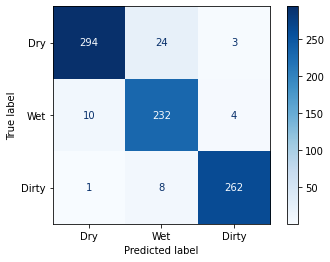

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


y_test = np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, predIdxs)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
figure(figsize=(50, 50), dpi=80)
disp.plot(cmap=plt.cm.Blues,values_format='')


plt.show

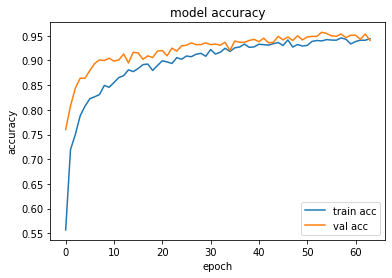

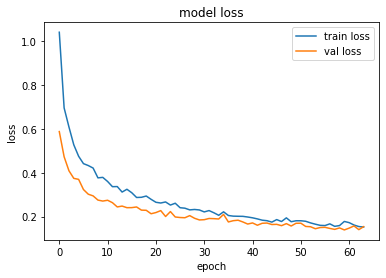

In [ ]:
# Plot the train and validation accuracies
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Plot the train and validation loss
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()